# Relax, Inc. Take Home Challenge

The data is available as two attached CSV files:

* takehome_user_engagement.csv
* takehome_users.csv

The data has the following two tables:
1. A user table ("takehome_users") with data on 12,000 users who signed up for the product in the last two years. This table includes:
 * name: the user's name
 * object_id: the user's id
 * email: email address
 * creation_source: how their account was created. This takes on one
of 5 values:
    
    * PERSONAL_PROJECTS: invited to join another user's personal workspace
    * GUEST_INVITE: invited to an organization as a guest (limited permissions)
    * ORG_INVITE: invited to an organization (as a full member)
    * SIGNUP: signed up via the website
    * SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)
    
 * creation_time: when they created their account
 * last_session_creation_time: unix timestamp of last login
 * opted_in_to_mailing_list: whether they have opted into receiving
marketing emails
 * enabled_for_marketing_drip: whether they are on the regular
marketing email drip
 * org_id: the organization (group of users) they belong to
 * invited_by_user_id: which user invited them to join (if applicable).

2. A usage summary table ("takehome_user_engagement") that has a row for each day that a user logged into the product.
Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven­day period, identify which factors predict future user adoption.
We suggest spending 1-2 hours on this, but you're welcome to spend more or less. Please send us a brief writeup of your findings (the more concise, the better ­­ no more than one page), along with any summary tables, graphs, code, or queries that can help us understand your approach. Please note any factors you considered or investigation you did, even if they did not pan out. Feel free to identify any further research or data you think would be valuable.

In [59]:
# importing modules
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from datetime import datetime, timedelta

In [60]:
# importing users data
users = pd.read_csv('takehome_users.csv', encoding='latin-1', index_col=0)
users.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
object_id,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


### Data Wrangling

In [61]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 9 columns):
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(3), object(4)
memory usage: 937.5+ KB


In [62]:
# changing columns to appropriate types
users.creation_time = pd.to_datetime(users.creation_time)
users.last_session_creation_time = pd.to_datetime(users.last_session_creation_time, unit='s')
users.creation_source = users.creation_source.astype('category')
users.opted_in_to_mailing_list = users.opted_in_to_mailing_list.astype('category')
users.enabled_for_marketing_drip = users.enabled_for_marketing_drip.astype('category')
users.invited_by_user_id = users.invited_by_user_id.astype('category')
users.org_id = users.org_id.astype('category')

In [63]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 9 columns):
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null category
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null category
enabled_for_marketing_drip    12000 non-null category
org_id                        12000 non-null category
invited_by_user_id            6417 non-null category
dtypes: category(5), datetime64[ns](2), object(2)
memory usage: 674.5+ KB


In [64]:
users.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
object_id,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


In [65]:
users.tail()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
object_id,,,,,,,,,
11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,2013-09-06 06:14:15,0,0,89,8263.0
11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,2013-01-15 18:28:37,0,0,200,NaN
11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,2014-04-27 12:45:16,1,1,83,8074.0
11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,2012-06-02 11:55:59,0,0,6,NaN
12000,2014-01-26 08:57:12,Lima Thaís,ThaisMeloLima@hotmail.com,SIGNUP,2014-01-26 08:57:12,0,1,0,NaN


In [66]:
# importing user engagement csv file
user_engagement = pd.read_csv('takehome_user_engagement.csv', parse_dates=['time_stamp'], index_col=[1, 0])
user_engagement.head()

visited
user_id time_stamp                  
1       2014-04-22 03:53:30        1
2       2013-11-15 03:45:04        1
        2013-11-29 03:45:04        1
        2013-12-09 03:45:04        1
        2013-12-25 03:45:04        1

In [67]:
user_engagement.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 207917 entries, (1, 2014-04-22 03:53:30) to (12000, 2014-01-26 08:57:12)
Data columns (total 1 columns):
visited    207917 non-null int64
dtypes: int64(1)
memory usage: 4.4 MB


In [68]:
user_engagement.describe()

,visited
count,207917.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


In [69]:
# resampling by 7day periods
engage = user_engagement.groupby(level=0).resample('7D', level=1).sum().dropna()

In [70]:
engage.head(20)

visited
user_id time_stamp                  
1       2014-04-22 03:53:30      1.0
2       2013-11-15 03:45:04      1.0
        2013-11-29 03:45:04      1.0
        2013-12-06 03:45:04      1.0
        2013-12-20 03:45:04      1.0
        2013-12-27 03:45:04      1.0
        2014-01-03 03:45:04      1.0
        2014-01-31 03:45:04      1.0
        2014-02-07 03:45:04      3.0
        2014-02-14 03:45:04      1.0
        2014-03-07 03:45:04      2.0
        2014-03-28 03:45:04      1.0
3       2013-03-19 23:14:52      1.0
4       2013-05-22 08:09:28      1.0
5       2013-01-22 10:14:20      1.0
6       2013-12-19 03:37:06      1.0
7       2012-12-20 13:24:32      1.0
10      2013-01-16 22:08:03      2.0
        2013-01-30 22:08:03      2.0
        2013-02-06 22:08:03      1.0

In [71]:
engage.describe()

,visited
count,68022.000000
mean,3.056614
std,2.034294
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,7.000000


In [72]:
# creating adopted user column
engage['adopted_user'] = engage['visited'] > 2

In [73]:
# making the column into boolean 
engage = engage[engage['adopted_user'] == True]

In [74]:
engage.head()

visited  adopted_user
user_id time_stamp                                
2       2014-02-07 03:45:04      3.0          True
10      2013-02-13 22:08:03      3.0          True
        2013-02-27 22:08:03      3.0          True
        2013-03-20 22:08:03      3.0          True
        2013-04-10 22:08:03      3.0          True

In [75]:
# reseting index
engage.reset_index(level=1, drop=True, inplace=True)

In [76]:
# dropping a column
engage.drop('visited', axis=1, inplace=True)

In [77]:
# removing duplicate user ids
engage = engage.reset_index().drop_duplicates(subset='user_id', keep='last').set_index('user_id')

In [78]:
engage.head()

,adopted_user
user_id,
2,True
10,True
20,True
42,True
43,True


In [79]:
# merging two dataframes
df = pd.concat([users, engage], axis=1)
df.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,NaN
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,True
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,NaN
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,NaN
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,NaN


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 10 columns):
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null category
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null category
enabled_for_marketing_drip    12000 non-null category
org_id                        12000 non-null category
invited_by_user_id            6417 non-null category
adopted_user                  1472 non-null object
dtypes: category(5), datetime64[ns](2), object(3)
memory usage: 768.2+ KB


In [81]:
# filling in for missing values
df.adopted_user.fillna(False, inplace=True)

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 10 columns):
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null category
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null category
enabled_for_marketing_drip    12000 non-null category
org_id                        12000 non-null category
invited_by_user_id            6417 non-null category
adopted_user                  12000 non-null bool
dtypes: bool(1), category(5), datetime64[ns](2), object(2)
memory usage: 686.2+ KB


### Exploratory Data Analysis

In [83]:
# user adoption percentage
df.adopted_user.sum() / len(df)

0.12266666666666666

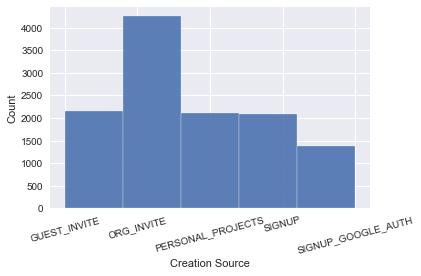

In [84]:
# plotting creation source
sns.set()
plt.hist(df.creation_source, bins=5, edgecolor='w', alpha=.9)
plt.xlabel('Creation Source')
plt.ylabel('Count')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

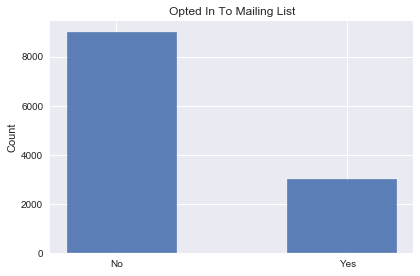

In [85]:
# plotting 
plt.hist(df.opted_in_to_mailing_list, bins=3, edgecolor='w', alpha=.9)
plt.xticks([0.15,.85], ['No', 'Yes'])
plt.title('Opted In To Mailing List')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

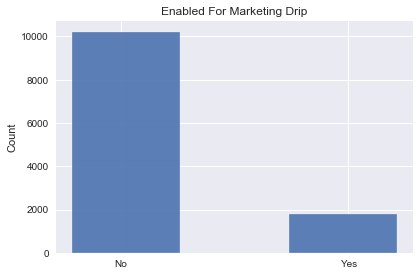

In [86]:
# plotting 
plt.hist(df.enabled_for_marketing_drip, bins=3, edgecolor='w', alpha=.9)
plt.xticks([0.15,.85], ['No', 'Yes'])
plt.title('Enabled For Marketing Drip')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [87]:
df.org_id.value_counts()[:10]

0     319
1     233
2     201
3     168
4     159
6     138
5     128
9     124
7     119
10    104
Name: org_id, dtype: int64

In [88]:
df.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,False
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,True
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,False
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,False
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,False


In [89]:
pred_df = df.drop(['name', 'email'], axis=1)

In [90]:
pred_df.head()

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,False
2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,True
3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,False
4,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,False
5,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,False


In [91]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 8 columns):
creation_time                 12000 non-null datetime64[ns]
creation_source               12000 non-null category
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null category
enabled_for_marketing_drip    12000 non-null category
org_id                        12000 non-null category
invited_by_user_id            6417 non-null category
adopted_user                  12000 non-null bool
dtypes: bool(1), category(5), datetime64[ns](2)
memory usage: 498.7 KB


In [92]:
pred_df['creation_time'] = pred_df['creation_time'].astype(int)
pred_df['last_session_creation_time'] = pred_df['last_session_creation_time'].astype(int)
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 8 columns):
creation_time                 12000 non-null int64
creation_source               12000 non-null category
last_session_creation_time    12000 non-null int64
opted_in_to_mailing_list      12000 non-null category
enabled_for_marketing_drip    12000 non-null category
org_id                        12000 non-null category
invited_by_user_id            6417 non-null category
adopted_user                  12000 non-null bool
dtypes: bool(1), category(5), int64(2)
memory usage: 498.7 KB


In [93]:
pred_df.head()

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
1,1398138810000000000,GUEST_INVITE,1398138810000000000,1,0,11,10803.0,False
2,1384487104000000000,ORG_INVITE,1396237504000000000,0,0,1,316.0,True
3,1363734892000000000,ORG_INVITE,1363734892000000000,0,0,94,1525.0,False
4,1369123768000000000,GUEST_INVITE,1369210168000000000,0,0,1,5151.0,False
5,1358417660000000000,GUEST_INVITE,1358849660000000000,0,0,193,5240.0,False


In [94]:
pred_df = pd.get_dummies(pred_df)
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Columns: 2993 entries, creation_time to invited_by_user_id_11999.0
dtypes: bool(1), int64(2), uint8(2990)
memory usage: 34.5 MB


In [95]:
pred_df.head()

,creation_time,last_session_creation_time,adopted_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,opted_in_to_mailing_list_0,opted_in_to_mailing_list_1,...,invited_by_user_id_11966.0,invited_by_user_id_11972.0,invited_by_user_id_11973.0,invited_by_user_id_11974.0,invited_by_user_id_11978.0,invited_by_user_id_11981.0,invited_by_user_id_11986.0,invited_by_user_id_11994.0,invited_by_user_id_11997.0,invited_by_user_id_11999.0
1,1398138810000000000,1398138810000000000,False,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1384487104000000000,1396237504000000000,True,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1363734892000000000,1363734892000000000,False,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1369123768000000000,1369210168000000000,False,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,1358417660000000000,1358849660000000000,False,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Predictive Model

In [96]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


X = pred_df.drop(['adopted_user'], axis=1)
y = pred_df['adopted_user']

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=21)

In [97]:
# Create the classifier
clf = RandomForestClassifier()

# Fit the classifier
clf.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = clf.predict(X_test)

# print accuracy score
accuracy = clf.score(X_test,y_test)
print("Random Forest accuracy:",accuracy)

# print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Random Forest accuracy: 0.965656565657
[[3458   21]
 [ 115  366]]
             precision    recall  f1-score   support

      False       0.97      0.99      0.98      3479
       True       0.95      0.76      0.84       481

avg / total       0.97      0.97      0.96      3960



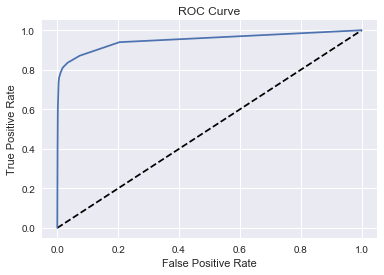

In [99]:
# Import necessary modules
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Compute predicted probabilities: y_pred_prob
y_pred_prob = clf.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [100]:
# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

AUC: 0.9500776563150809


### Extracting most important features

In [106]:
print((clf.feature_importances_), X.columns)

[  1.12813640e-01   5.52376703e-01   4.72875074e-03 ...,   4.85906802e-04
   0.00000000e+00   2.86564469e-07] Index(['creation_time', 'last_session_creation_time',
       'creation_source_GUEST_INVITE', 'creation_source_ORG_INVITE',
       'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP',
       'creation_source_SIGNUP_GOOGLE_AUTH', 'opted_in_to_mailing_list_0',
       'opted_in_to_mailing_list_1', 'enabled_for_marketing_drip_0',
       ...
       'invited_by_user_id_11966.0', 'invited_by_user_id_11972.0',
       'invited_by_user_id_11973.0', 'invited_by_user_id_11974.0',
       'invited_by_user_id_11978.0', 'invited_by_user_id_11981.0',
       'invited_by_user_id_11986.0', 'invited_by_user_id_11994.0',
       'invited_by_user_id_11997.0', 'invited_by_user_id_11999.0'],
      dtype='object', length=2992)


In [125]:
important_features_dict = {}
for x,i in enumerate(clf.feature_importances_):
    important_features_dict[x]=i


important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)

print ('Top 10 important features: %s' %important_features_list[:10])

Top 10 important features: [1, 0, 3, 8, 2, 4, 5, 7, 6, 10]


In [131]:
print('Top 10 important features:\n ')
print("\n".join(X.columns[[1, 0, 3, 8, 2, 4, 5, 7, 6, 10]]))

Top 10 important features:
 
last_session_creation_time
creation_time
creation_source_ORG_INVITE
opted_in_to_mailing_list_1
creation_source_GUEST_INVITE
creation_source_PERSONAL_PROJECTS
creation_source_SIGNUP
opted_in_to_mailing_list_0
creation_source_SIGNUP_GOOGLE_AUTH
enabled_for_marketing_drip_1


I printed top 10 most important features (or factors) above. It looks like features** creation time, creation source **(*order of importance: ORG_INVITE, GUEST_INVITE, PESONAL_PROJECTS, SIGNUPS*),** opted in to mailing list & enabled for marketing drip **are most important factors that lead to user adoption.